## General information
In Don't Overfit! II competition we have a binary classification task. 300 columns, 250 training samples and 79 times more samples in test data! We need to be able to build a model without overfitting.

In this kernel I'll write the following things:

  * EDA on the features and trying to get some insights;
  * Using permutation importance to select most impactful features;
  * Comparing various models: bayer classification, linear models, tree based models;
  * Trying various approaches to feature selection including taking top features from eli5 and shap;
  * Hyperparameter optimization for models;
  * Feature generation;
  * Other things
  
 ![alt_text](https://cdn-images-1.medium.com/max/1600/1*vuZxFMi5fODz2OEcpG-S1g.png)

## Importing Libraries

In [220]:
!pip install kaggle
!pip install -U --pre tensorflow
!pip install -q seaborn
!pip install lightgbm
!pip install mlxtend
!pip install eli5
!pip install xgboost
!pip install catboost
!pip install plotly
!pip install statsmodels
!pip install shap
!pip install pdpbox

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0a0)
     |████████████████████████████████| 57.7MB 50.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [3]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.neighbors import *
from sklearn.feature_selection import *
from sklearn import linear_model
from scipy import stats

import shap
import eli5
from eli5.sklearn import PermutationImportance
import statsmodels.api as sm
from mlxtend.feature_selection import *
from mlxtend.plotting import *

# is_python = "inline" in matplotlib.get_backend()
# if is_python:
#   from IPython import Display

import json
import ast
import time
import sys
import os
import math
import random
import datetime

import warnings 
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"8147626534ea9d5981d92ed48c6b1eb1"}'}

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dont-overfit-ii

  0% 0.00/144k [00:00<?, ?B/s]
100% 144k/144k [00:00<00:00, 43.3MB/s]
 41% 5.00M/12.3M [00:00<00:00, 26.6MB/s]
100% 12.3M/12.3M [00:00<00:00, 48.5MB/s]
  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 144MB/s]


In [7]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv.zip  train.csv


In [8]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [9]:
!ls

kaggle.json  sample_submission.csv  test.csv.zip
sample_data  test.csv		    train.csv


## Data Preprocessing and Vizualization

In [10]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape
test.shape

(250, 302)

(19750, 301)

In [0]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail()

,level_0,level_1,0
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


## Basic Modelling

In [0]:
# X_train = train.drop(['id','target'],axis=1)
# y_train = train['target']
# X_test = test.drop(['id'],axis=1)
# n_fold = 20
# folds = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=0)
# repeated_folds = RepeatedStratifiedKFold(n_splits=20,n_repeats=20,random_state=0)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [0]:
# def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
#   oof = np.zeros(len(X))
#   prediction = np.zeros(len(X_test))
#   scores = []
#   feature_importance = pd.DataFrame()
#   for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]
    
#     if model_type == "lgb":
#       train_data = lgb.Dataset(X_train,label=y_train)
#       valid_data = lgb.Dataset(X_valid,label=y_valid)
#       model = lgb.train(params, train_data, num_boost_round=2000,valid_sets=[train_data, valid_data], verbose_eval = 500, early_stopping_rounds=200)
#       y_pred_valid = model.predict(X_valid)
#       y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
      
#     if model_type == 'xgb':
#       train_data = xgb.DMatrix(data=X_train, label = y_train, feature_names=X_train.columns)
#       valid_data = xgb.DMatrix(data=X_valid,label = y_valid, feature_names=X_train.columns)
#       watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
#       model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#       y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#       y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns),ntree_limit=model.best_ntree_limit)
    
#     if model_type == 'cat':
#       model = CatBoostClassifier(iterations=20000, eval_metrix='AUC', **params)
#       model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)
#       y_pred_valid = model.predict(X_valid)
#       y_pred = model.predict(X_test)
    
#     if model_type == "sklearn":
#       model = model
#       model.fit(X_train, y_train)
#       y_pred_valid(X_valid).reshape(-1,)
#       score = roc_auc_score(y_valid, y_pred_valid)
#       y_pred = model.predict_proba(X_test)[:,1]
      
#     if model_type == 'glm':
#       model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
#       model_results = model.fit()
#       model_results.predict(X_test)
#       y_pred_valid = model_results.predict(X_valid).reshape(-1,)
#       score = roc_auc_score(y_valid, y_pred_valid)
#       y_pred = model_results.predict(X_test)
    
#     oof

In [0]:
!ls

kaggle.json  predictions.csv  sample_submission.csv  test.csv.zip
pred.csv     sample_data      test.csv		     train.csv


## Neural Network Implementation

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold 

In [0]:
X = train.drop(['id','target'],axis=1)
y= train['target']
X_test = test.drop(['id'],axis=1)
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=0)
repeated_folds = RepeatedStratifiedKFold(n_splits=20,n_repeats=20,random_state=0)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [45]:
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(36,activation='relu',kernel_initializer="he_uniform"))
model.add(Dropout(0.3))
model.add(Dense(18,activation='relu',kernel_initializer="he_uniform"))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid',kernel_initializer="he_uniform"))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.003),metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 36)                10836     
_________________________________________________________________
dropout_4 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 18)                666       
_________________________________________________________________
dropout_5 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=0)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.5,min_lr=0.0009)

In [47]:
N_SPLITS = 10
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True).split(X, y))
preds_val = []
y_val = []
best_models = []

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))
    X_train, y_train, X_val, y_val = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),callbacks=[early_stopping,reduce_lr], verbose=0)
    model.evaluate(X_val,y_val)
    score = roc_auc_score(y_val, model.predict(X_val))
    print(score)

Beginning fold 1


25/25 [==============================] - 0s 172us/sample - loss: 0.9147 - accuracy: 0.6400


[0.9146655797958374, 0.64]

0.6319444444444444
Beginning fold 2


25/25 [==============================] - 0s 336us/sample - loss: 0.0054 - accuracy: 1.0000


[0.0053504216484725475, 1.0]

1.0
Beginning fold 3


25/25 [==============================] - 0s 52us/sample - loss: 4.4211e-07 - accuracy: 1.0000


[4.4210511873643554e-07, 1.0]

1.0
Beginning fold 4


25/25 [==============================] - 0s 153us/sample - loss: 1.4500e-07 - accuracy: 1.0000


[1.449978839218602e-07, 1.0]

1.0
Beginning fold 5


25/25 [==============================] - 0s 212us/sample - loss: 5.8078e-08 - accuracy: 1.0000


[5.8077848308357716e-08, 1.0]

1.0
Beginning fold 6


25/25 [==============================] - 0s 64us/sample - loss: 7.7867e-09 - accuracy: 1.0000


[7.786688627220428e-09, 1.0]

1.0
Beginning fold 7


25/25 [==============================] - 0s 135us/sample - loss: 3.0599e-09 - accuracy: 1.0000


[3.0598663602887655e-09, 1.0]

1.0
Beginning fold 8


25/25 [==============================] - 0s 253us/sample - loss: 5.6760e-10 - accuracy: 1.0000


[5.675981906705374e-10, 1.0]

1.0
Beginning fold 9


25/25 [==============================] - 0s 204us/sample - loss: 4.0515e-10 - accuracy: 1.0000


[4.0515260590900937e-10, 1.0]

1.0
Beginning fold 10


25/25 [==============================] - 0s 54us/sample - loss: 2.1316e-09 - accuracy: 1.0000


[2.1316186593622888e-09, 1.0]

1.0


In [0]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(-1)
df = pd.DataFrame()
df['id'] = test['id']
df['target'] = predictions
df.to_csv('nn.csv',index=False)

In [0]:
# Fine Tuning Above Model Gave me an accuracy of 71% and rank 1500+. Lets see if we can make this better

## Ensemble Method

### Importing Libraries

In [244]:
from __future__ import absolute_import, print_function, division

import os
import sys
import ast
import csv
import time
import json
import random
import datetime

import sklearn
from sklearn.model_selection import *
from sklearn.decomposition import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.tree import *

from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import xgboost as xgb

import scipy
import numpy as np
import pandas as pd
from pandas import get_dummies
pd.set_option("max_columns",None)
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.plotly as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
%precision 2

import shap
import eli5
from eli5 import permutation_importance

import warnings
warnings.filterwarnings("ignore")

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'%.2f'

In [0]:
fold_n = 5
folds = StratifiedKFold(n_splits=fold_n,shuffle=True,random_state=10)
plt.style.use('seaborn-talk')

  ### Exploratory Data Analysis
  * Data Collection
  * Data Vizualization
  * Data Preprocessing
  * Data Cleaning

#### Data Collection

In [246]:
[i for i in os.listdir() if ".csv" in i]

['test.csv.zip', 'nn.csv', 'sample_submission.csv', 'test.csv', 'train.csv']

In [247]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,target
0,250,0
1,251,0
2,252,0
3,253,0
4,254,0


In [248]:
train.shape
test.shape
sample_submission.shape

(250, 302)

(19750, 301)

(19750, 2)

In [249]:
train.head()
test.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.8

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,1.291,0.507,-0.317,1.848,-0.232,-0.340,-0.051,0.804,0.764,1.860,0.262,1.112,-0.491,-1.039,-0.492,0.183,-0.671,-1.313,0.149,0.244,1.072,-1.003,0.832,-1.075,1.988,1.201,-2.065,-0.826,-0.016,0.490,0.191,0.732,1.235,-0.867,-0.616,0.340,0.788,-0.044,0.305,-0.819,-0.447,-1.625,-1.005,-0.653,-0.371,1.556,0.754,-0.688,0.061,0.644,0.645,-0.222,-2.174,-0.610,-1.092,0.917,-1.010,-1.021,-0.179,1.732,-0.366,-1.694,1.038,-0.721,0.112,-0.783,0.940,-1.803,1.295,-1.031,0.452,1.198,-0.206,0.051,-1.055,1.740,-0.910,-0.509,-0.987,-1.011,0.718,0.375,0.101,0.137,-1.585,0.532,-1.201,1.210,-0.374,0.300,-0.110,-0.248,1.464,0.056,-0.038,-0.482,0.585,-1.263,0.993,-0.639,-1.337,0.225,1.640,-1.807,-1.983,-0.638,-0.432,1.890,0.506,1.091,-0.635,1.072,0.262,0.418,-1.294,0.868,0.728,0.618,0.540,1.981,-0.246,0.516,-0.373,0.954,-0.854,-1.241,-0.861,0.317,-0.611,-0.179,-1.658,-1.397,-0.988,-0.316,1.808,0.930,1.098,0.997,0.901,1.095,-0.464,2.592,0.846,1.060,-0.676,0.376,0.047,1.265,1.218,1.003,1.219,-0.624,-1.316,0.921,3.472,-1.123,0.037,0.927,-0.695,-0.046,0.270,0.847,-1.072,0.315,2.522,0.376,-0.015,-1.283,-0.650,-0.106,0.747,0.612,-0.838,0.713,0.048,-1.073,0.657,-0.542,-0.269,-0.482,0.329,0.534,0.337,0.118,-0.164,-0.538,-0.285,1.375,1.194,-0.258,-0.298,1.578,-0.488,1.424,1.106,0.363,-2.007,-0.091,0.551,0.388,0.422,0.099,0.378,-1.333,-1.102,2.145,0.745,0.345,-0.904,0.425,-0.273,0.547,-0.184,0.458,0.182,0.592,0.966,0.540,-1.382,0.069,0.131,-0.068,-0.400,0.413,-0.030,0.890,1.000,-0.774,0.340,2.345,2.748,0.774,-0.355,0.574,0.027,1.437,-0.877,0.532,-0.348,0.926,1.308,-0.120,-1.460,0.755,0.426,1.667,-0.264,1.266,0.962,1.285,1.176,0.824,0.928,1.372,1.505,0.645,0.641,-1.132,1.009,0.998,0.210,-1.634,1.046,0.114,-0.806,0.301,0.145,-0.684,0.794,-0.290,-1.688,0.313,1.140,0.447,-0.616,1.294,0.785,0.453,1.550,-0.866,1.007,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,1.356,-1.086,0.322,0.876,-0.563,-1.394,0.385,1.891,-2.107,-0.636,-0.055,-0.843,0.041,0.253,0.557,0.475,-0.839,-1.146,1.210,1.427,0.347,1.077,-0.194,0.323,0.543,0.894,1.190,0.342,-0.858,0.756,1.350,-0.414,0.748,2.014,0.858,0.025,1.343,0.784,-0.418,-0.515,0.694,-1.097,0.559,-0.799,-0.936,1.483,1.670,1.403,0.457,-1.564,0.049,0.550,-0.085,-0.561,-0.529,-1.563,-0.781,-0.532,0.375,-0.727,-0.053,-0.383,-0.123,1.573,-0.898,-0.070,0.811,-0.036,0.720,1.691,-0.673,-0.421,-1.665,0.099,0.089,2.032,-1.132,-1.827,-0.017,-1.748,-0.717,2.004,1.216,1.547,1.322,0.481,1.819,-0.809,0.617,-0.763,-0.154,-0.847,-0.981,0.274,-1.856,0.808,-0.599,0.998,-0.286,0.649,0.612,-1.002,1.258,0.149,0.252,1.093,-0.344,0.349,-1.386,-0.518,1.478,-1.261,2.206,-0.053,-1.191,-1.118,0.402,0.786,-0.345,-0.387,0.558,2.202,-2.056,1.502,1.191,-0.404,-2.183,1.559,1.077,-0.659,0.339,1.113,0.286,-0.424,-1.061,-0.748,-1.148,1.705,1.239,-0.912,-0

In [250]:
train.tail()
test.tail()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
245,245,0.0,-1.199,0.466,-0.908,2.771,1.631,0.931,0.182,-0.652,-0.512,0.400,1.608,0.937,1.663,0.696,-1.874,1.044,0.851,-1.070,-0.095,-1.386,-0.219,0.101,0.250,-0.465,-0.455,0.538,2.581,-1.612,1.166,1.682,-1.574,-0.304,0.355,-1.416,-0.823,0.359,-0.463,-1.869,-1.245,0.487,-0.920,0.175,-0.585,0.346,-0.964,-1.019,0.896,0.391,2.001,0.504,-0.143,0.878,-1.251,0.100,-0.006,0.044,0.197,0.022,2.003,0.616,0.432,0.191,-1.302,0.143,-0.051,-0.330,0.086,0.134,0.682,1.870,0.761,0.911,-0.641,0.274,1.169,1.781,-1.696,-1.134,0.216,-1.126,-0.831,1.184,0.643,-0.253,-0.389,0.292,1.436,-0.205,-0.225,-0.292,-1.044,0.369,-0.382,-0.281,0.263,-0.310,1.437,0.278,-0.570,0.620,0.216,-2.865,2.308,1.384,-1.232,0.534,-1.916,-2.016,-0.064,0.232,2.814,0.469,0.298,-1.183,1.167,-0.285,-2.113,-4.270,1.142,-2.363,-2.110,0.131,0.526,-0.554,0.153,0.438,0.077,0.179,0.935,-0.575,-2.361,-0.052,1.908,0.204,-1.453,0.112,0.134,0.444,-0.002,-0.378,-0.003,1.027,-1.357,0.722,0.959,0.103,-0.411,-0.612,0.469,-1.078,-0.686,0.555,0.548,-1.121,0.305,1.112,-0.594,2.930,-1.252,-0.693,-0.402,0.033,-0.469,0.605,-1.550,0.538,-0.913,0.202,0.785,-0.484,-0.010,0.890,-1.972,1.256,-1.045,-0.704,-1.405,-1.990,1.906,-0.321,0.917,0.863,-0.415,0.005,0.975,-0.415,0.105,-1.432,-1.689,-1.658,0.625,-0.463,0.287,0.725,0.223,-1.753,1.005,0.013,1.144,0.061,-0.693,-1.238,1.129,0.541,0.657,-0.317,0.461,-1.243,0.079,0.935,1.014,0.346,2.645,-0.791,0.397,0.187,-0.291,0.223,0.251,0.007,-0.912,-0.466,-0.674,-0.188,0.438,-0.767,-1.079,-1.223,1.148,1.704,-0.862,-0.412,0.083,0.738,1.024,-0.759,0.349,-0.758,-0.512,0.157,-2.454,-1.011,-0.655,0.826,0.154,1.212,0.172,0.013,-1.287,1.101,1.128,0.749,-1.166,-0.286,-1.478,-0.806,0.291,-0.231,-1.359,-0.218,1.588,-1.167,1.500,-1.643,-1.944,-1.121,1.055,1.794,0.986,-1.461,0.329,1.903,0.468,-1.826,-2.128,1.644,-0.598,0.176,-0.517,-1.146,1.911,-0.814,-0.073,0.155,0.323,1.060,0.324,0.460,2.213,-2.360,0.724,0.177,-0.039,0.759,0.461,-0.243,0.525,0.281,-0.255,-1.136
246,246,0.0,0.237,0.233,-0.380,-1.748,0.839,-0.721,-0.114,0.005,-1.788,1.416,-0.683,1.079,0.195,1.879,-0.025,-0.138,-0.276,-0.318,-0.485,0.408,-0.261,-0.536,0.276,0.568,-0.757,-0.915,0.989,-0.781,0.982,1.308,0.299,1.743,0.868,0.001,-0.261,-0.620,0.459,0.116,0.821,-1.797,0.680,-0.631,0.543,0.860,-0.482,-1.305,-1.503,-0.135,0.006,0.119,0.982,2.680,2.105,0.056,-1.216,0.700,0.589,-0.472,-2.084,-1.012,-0.927,0.304,1.363,-0.363,-0.263,-1.019,-0.853,-0.797,-1.592,-0.203,0.255,0.612,-0.176,0.588,-0.046,-2.174,-0.444,0.296,-0.765,1.390,0.684,-1.000,-0.361,1.026,-0.678,0.265,-0.676,-0.786,1.991,1.095,-0.523,-0.748,-0.742,0.494,-1.075,0.913,-0.080,1.256,1.141,-0.290,-1.380,-0.978,-1.617,0.094,-0.688,-1.226,0.301,1.335,0.510,-1.630,0.203,-1.358,0.545,0.555,0.963,0.966,-0.459,1.712,1.261,-1.293,1.632,-0.168,-0.209,-0.451,-0.576,0.269,0.870,-1.341,0.065,0.630,1.243,2.260,-1.076,-0.502,0.395,-1.172,2.602,-1.319,1.635,0.609,-2.415,0.920,-0.541,-0.671,-

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
19745,19995,1.069,0.517,-0.690,0.241,0.913,-0.859,0.093,-0.359,-0.047,0.713,2.191,0.774,-0.110,-0.721,0.375,0.577,-0.192,-1.345,0.042,0.786,0.774,2.458,0.634,-0.664,-0.486,0.136,-0.506,0.509,-2.206,-1.035,-0.828,0.335,-0.963,0.946,1.728,0.256,-0.938,0.041,-0.112,1.684,-0.670,0.592,-0.245,0.834,0.334,-0.830,-0.281,0.750,1.488,1.768,-0.145,0.745,0.788,-1.264,0.605,0.431,0.137,0.945,1.561,1.021,-0.382,0.347,-0.120,-0.202,-1.001,0.470,-0.539,-0.794,0.349,-1.704,-0.666,-0.071,0.597,-0.307,0.919,0.442,1.773,0.745,0.670,0.640,-1.186,-1.540,0.691,-0.363,-0.081,0.239,-1.284,0.192,1.405,0.057,-0.380,0.768,0.108,-0.691,1.073,-3.217,0.447,-0.814,0.916,0.740,1.438,-2.081,0.643,-0.351,0.942,0.245,0.037,-0.192,-0.094,-0.109,-1.436,-0.841,0.600,-0.104,0.386,0.707,0.076,0.634,0.876,1.913,0.659,-0.442,0.802,0.735,-0.297,0.072,-0.460,-1.227,0.257,0.943,-0.140,-0.696,-0.256,-0.303,-0.618,-0.573,-0.441,0.652,-1.971,-0.451,-0.982,-0.491,-0.295,-0.289,1.005,0.014,-1.878,0.684,0.740,-0.452,-0.603,1.395,0.120,-0.197,1.815,-0.113,-1.461,2.571,-0.282,0.573,0.025,-0.470,2.302,1.360,-0.832,-0.680,-1.026,-0.814,0.110,-0.696,1.825,0.756,2.721,-1.287,-0.372,-0.415,-0.417,-0.211,-1.280,-0.553,-0.281,0.066,-0.339,-0.537,0.191,-1.272,0.093,-0.273,0.068,-1.799,0.281,-1.334,-0.130,0.515,0.404,0.058,0.284,-1.158,-0.815,-1.022,-0.073,-0.871,0.751,-1.160,0.315,-1.419,-0.237,-1.064,-0.628,0.672,1.016,-0.248,0.091,-0.996,-0.635,-0.341,-0.513,1.122,1.252,-0.176,0.603,-0.480,-0.503,-0.558,-0.434,-0.693,0.258,0.017,-0.995,-0.464,0.057,0.033,1.362,-1.546,0.444,-0.929,0.265,-1.936,-0.190,-0.393,-2.564,-0.499,1.689,-0.948,0.048,0.612,0.552,-0.841,0.960,-0.141,-1.313,1.528,0.826,0.866,1.833,-1.624,-0.322,0.670,0.185,-0.650,-0.079,-0.853,0.708,0.301,0.636,-0.688,0.220,-1.192,1.257,-0.664,-1.258,-1.199,-0.145,0.581,-0.613,2.775,-0.254,-0.027,-1.088,-0.461,-0.356,-0.622,-0.228,-0.490,1.011,0.655,1.088,-0.796,-0.261,-1.219,0.495,1.021,0.126,-0.353,-0.092,0.996,-0.381,-0.748,1.567,1.165
19746,19996,-0.529,0.438,0.672,1.436,-0.720,0.698,-0.350,2.150,-1.241,-0.167,-0.188,0.541,-0.392,1.727,-0.965,0.550,-2.164,-0.523,-0.144,-0.931,0.703,0.464,-0.919,-0.867,-1.345,-0.634,0.121,0.877,-1.665,-0.086,-0.703,-0.874,0.676,1.671,0.356,0.365,-1.177,1.380,1.987,-1.418,-1.969,2.604,-0.007,-1.492,2.104,-0.150,-0.968,0.756,-0.835,1.165,-0.931,-0.168,1.868,1.092,1.659,-0.403,0.462,0.753,-1.900,0.859,-0.247,-1.310,0.627,0.218,-1.960,0.994,0.302,1.975,-2.716,0.210,0.811,-1.423,-0.770,-0.476,0.485,-0.564,0.603,-0.687,-0.981,-0.465,0.887,-1.992,-1.404,1.690,-1.352,0.408,0.803,1.379,-0.097,-0.596,0.982,-0.235,1.783,0.645,2.084,-1.488,-1.414,-0.438,0.889,-0.557,-0.045,-0.488,-0.679,-0.012,-0.008,-1.564,0.574,0.218,-1.895,-0.038,0.692,0.933,1.203,1.164,0.428,1.484,0.631,0.777,-1.907,1.346,1.130,0.755,1.292,0.286,0.384,-0.036,1.833,0.455,-0.138,1.009,0.048,-1.255,1.025,-2.132,0.915,-1.542,0.113,-2.076,-0.250,-1.124,-1.417,1.247,0.5

In [251]:
train.columns

Index(['id', 'target', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '290', '291', '292', '293', '294', '295', '296', '297', '298', '299'],
      dtype='object', length=302)

In [252]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 589.9 KB


In [253]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,250.0,124.500000,72.312977,0.000,62.25000,124.5000,186.75000,249.000
target,250.0,0.640000,0.480963,0.000,0.00000,1.0000,1.00000,1.000
0,250.0,0.023292,0.998354,-2.319,-0.64475,-0.0155,0.67700,2.567
1,250.0,-0.026872,1.009314,-2.931,-0.73975,0.0570,0.62075,2.419
2,250.0,0.167404,1.021709,-2.477,-0.42525,0.1840,0.80500,3.392
3,250.0,0.001904,1.011751,-2.359,-0.68650,-0.0165,0.72000,2.771
4,250.0,0.001588,1.035411,-2.566,-0.65900,-0.0230,0.73500,2.901
5,250.0,-0.007304,0.955700,-2.845,-0.64375,0.0375,0.66050,2.793
6,250.0,0.032052,1.006657,-2.976,-0.67500,0.0605,0.78325,2.546
7,250.0,0.078412,0.939731,-3.444,-0.55075,0.1835,0.76625,2.846


In [254]:
train.isnull().any().any()

False

In [255]:
test.isnull().any().any()

False

#### Data Vizualization

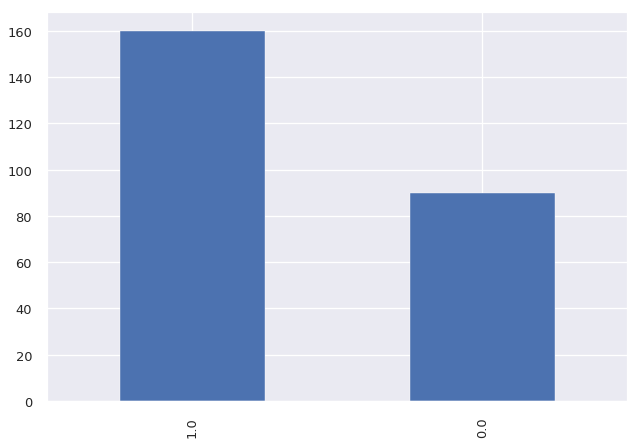

In [256]:
train['target'].value_counts().plot.bar()
plt.grid(True)

Text(0.5, 1.0, 'Std Frequency')

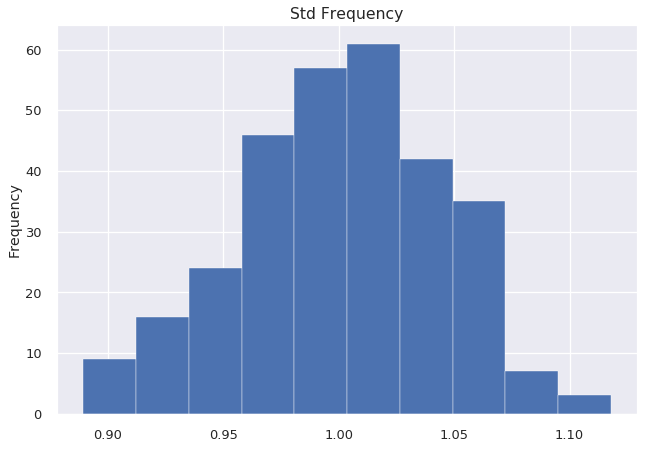

In [257]:
train[train.columns[2:]].std().plot(kind='hist')
plt.title('Std Frequency')
plt.grid(True)

Text(0.5, 1.0, 'Mean Frequency')

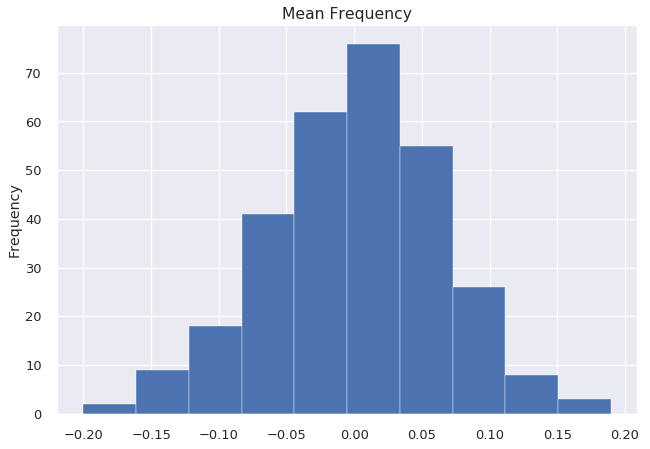

In [258]:
train[train.columns[2:]].mean().plot(kind='hist')
plt.title('Mean Frequency')
plt.grid(True)

Distribution of first 28 columns


<Figure size 2016x2016 with 0 Axes>

(array([ 7., 14., 27., 40., 52., 41., 29., 23., 11.,  6.]),
 array([-2.32, -1.83, -1.34, -0.85, -0.36,  0.12,  0.61,  1.1 ,  1.59,
         2.08,  2.57]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '0')

(array([ 3.,  7., 15., 36., 34., 54., 54., 24., 15.,  8.]),
 array([-2.93, -2.4 , -1.86, -1.33, -0.79, -0.26,  0.28,  0.81,  1.35,
         1.88,  2.42]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '1')

(array([ 6., 14., 29., 45., 58., 51., 28., 14.,  4.,  1.]),
 array([-2.48, -1.89, -1.3 , -0.72, -0.13,  0.46,  1.04,  1.63,  2.22,
         2.81,  3.39]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '2')

(array([ 8., 17., 27., 44., 46., 45., 32., 23.,  5.,  3.]),
 array([-2.36, -1.85, -1.33, -0.82, -0.31,  0.21,  0.72,  1.23,  1.75,
         2.26,  2.77]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '3')

(array([ 9.,  8., 30., 40., 60., 38., 35., 22.,  5.,  3.]),
 array([-2.57, -2.02, -1.47, -0.93, -0.38,  0.17,  0.71,  1.26,  1.81,
         2.35,  2.9 ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '4')

(array([ 3.,  7., 22., 34., 56., 52., 51., 17.,  4.,  4.]),
 array([-2.85, -2.28, -1.72, -1.15, -0.59, -0.03,  0.54,  1.1 ,  1.67,
         2.23,  2.79]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '5')

(array([ 1.,  7., 11., 38., 50., 45., 46., 31., 17.,  4.]),
 array([-2.98, -2.42, -1.87, -1.32, -0.77, -0.22,  0.34,  0.89,  1.44,
         1.99,  2.55]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '6')

(array([ 1.,  4.,  5., 22., 55., 56., 62., 34.,  9.,  2.]),
 array([-3.44, -2.81, -2.19, -1.56, -0.93, -0.3 ,  0.33,  0.96,  1.59,
         2.22,  2.85]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '7')

(array([ 6.,  6., 21., 30., 47., 52., 53., 25.,  5.,  5.]),
 array([-2.77, -2.24, -1.71, -1.18, -0.66, -0.13,  0.4 ,  0.93,  1.46,
         1.98,  2.51]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '8')

(array([ 8., 18., 26., 49., 51., 40., 29., 22.,  6.,  1.]),
 array([-2.36, -1.83, -1.3 , -0.77, -0.23,  0.3 ,  0.83,  1.36,  1.89,
         2.43,  2.96]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '9')

(array([ 2.,  5., 28., 29., 51., 67., 40., 20.,  6.,  2.]),
 array([-3.3 , -2.64, -1.99, -1.33, -0.67, -0.02,  0.64,  1.3 ,  1.96,
         2.61,  3.27]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '10')

(array([ 4.,  7., 18., 35., 55., 58., 42., 20.,  7.,  4.]),
 array([-2.85, -2.27, -1.68, -1.1 , -0.51,  0.07,  0.66,  1.24,  1.83,
         2.41,  3.  ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '11')

(array([ 3., 16., 21., 40., 36., 54., 44., 23.,  9.,  4.]),
 array([-2.68, -2.14, -1.6 , -1.06, -0.52,  0.02,  0.57,  1.11,  1.65,
         2.19,  2.73]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '12')

(array([ 6.,  9., 29., 36., 47., 52., 36., 20., 10.,  5.]),
 array([-2.6 , -2.07, -1.55, -1.02, -0.5 ,  0.03,  0.55,  1.08,  1.6 ,
         2.13,  2.65]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '13')

(array([ 1.,  2., 14., 33., 55., 67., 48., 23.,  5.,  2.]),
 array([-3.27, -2.66, -2.04, -1.42, -0.8 , -0.18,  0.44,  1.06,  1.68,
         2.29,  2.91]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '14')

(array([ 1.,  1., 11., 27., 38., 56., 58., 38., 16.,  4.]),
 array([-3.51, -2.91, -2.31, -1.71, -1.1 , -0.5 ,  0.1 ,  0.7 ,  1.3 ,
         1.91,  2.51]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '15')

(array([ 6., 12., 37., 66., 38., 49., 26.,  9.,  6.,  1.]),
 array([-2.48, -1.9 , -1.32, -0.75, -0.17,  0.41,  0.98,  1.56,  2.13,
         2.71,  3.29]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '16')

(array([ 1.,  3.,  6., 21., 47., 61., 53., 34., 16.,  8.]),
 array([-3.62, -3.01, -2.41, -1.8 , -1.2 , -0.59,  0.01,  0.62,  1.22,
         1.83,  2.43]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '17')

(array([ 3., 10., 28., 37., 50., 54., 30., 23., 12.,  3.]),
 array([-2.43, -1.93, -1.43, -0.93, -0.43,  0.06,  0.56,  1.06,  1.56,
         2.06,  2.56]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '18')

(array([ 2.,  9., 13., 35., 55., 55., 43., 25., 10.,  3.]),
 array([-3.23, -2.62, -2.01, -1.4 , -0.79, -0.18,  0.43,  1.04,  1.65,
         2.26,  2.87]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '19')

(array([ 1.,  8., 25., 38., 54., 44., 39., 27., 11.,  3.]),
 array([-3.02, -2.45, -1.88, -1.31, -0.73, -0.16,  0.41,  0.98,  1.56,
         2.13,  2.7 ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '20')

(array([ 3.,  7., 18., 37., 55., 46., 43., 20., 15.,  6.]),
 array([-2.77, -2.23, -1.68, -1.14, -0.59, -0.04,  0.5 ,  1.05,  1.6 ,
         2.14,  2.69]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '21')

(array([ 4.,  4., 13., 42., 38., 55., 50., 26., 16.,  2.]),
 array([-2.96, -2.41, -1.85, -1.29, -0.74, -0.18,  0.38,  0.93,  1.49,
         2.05,  2.6 ]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '22')

(array([ 5., 10., 23., 34., 47., 51., 43., 20., 10.,  7.]),
 array([-2.49, -2.  , -1.52, -1.03, -0.55, -0.06,  0.42,  0.91,  1.39,
         1.88,  2.36]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '23')

(array([ 3., 11., 12., 42., 60., 54., 45., 16.,  5.,  2.]),
 array([-3.11, -2.5 , -1.9 , -1.3 , -0.69, -0.09,  0.51,  1.12,  1.72,
         2.32,  2.93]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '24')

(array([ 3.,  5., 12., 35., 54., 64., 38., 26.,  9.,  4.]),
 array([-2.94, -2.35, -1.76, -1.17, -0.58,  0.02,  0.61,  1.2 ,  1.79,
         2.38,  2.98]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '25')

(array([ 2.,  7., 14., 28., 50., 55., 40., 31., 14.,  9.]),
 array([-2.93, -2.38, -1.83, -1.28, -0.73, -0.18,  0.38,  0.93,  1.48,
         2.03,  2.58]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '26')

(array([ 1.,  3., 11., 27., 54., 43., 49., 39., 16.,  7.]),
 array([-2.94, -2.42, -1.89, -1.37, -0.84, -0.32,  0.21,  0.73,  1.26,
         1.78,  2.31]),
 <a list of 10 Patch objects>)

Text(0.5, 1.0, '27')

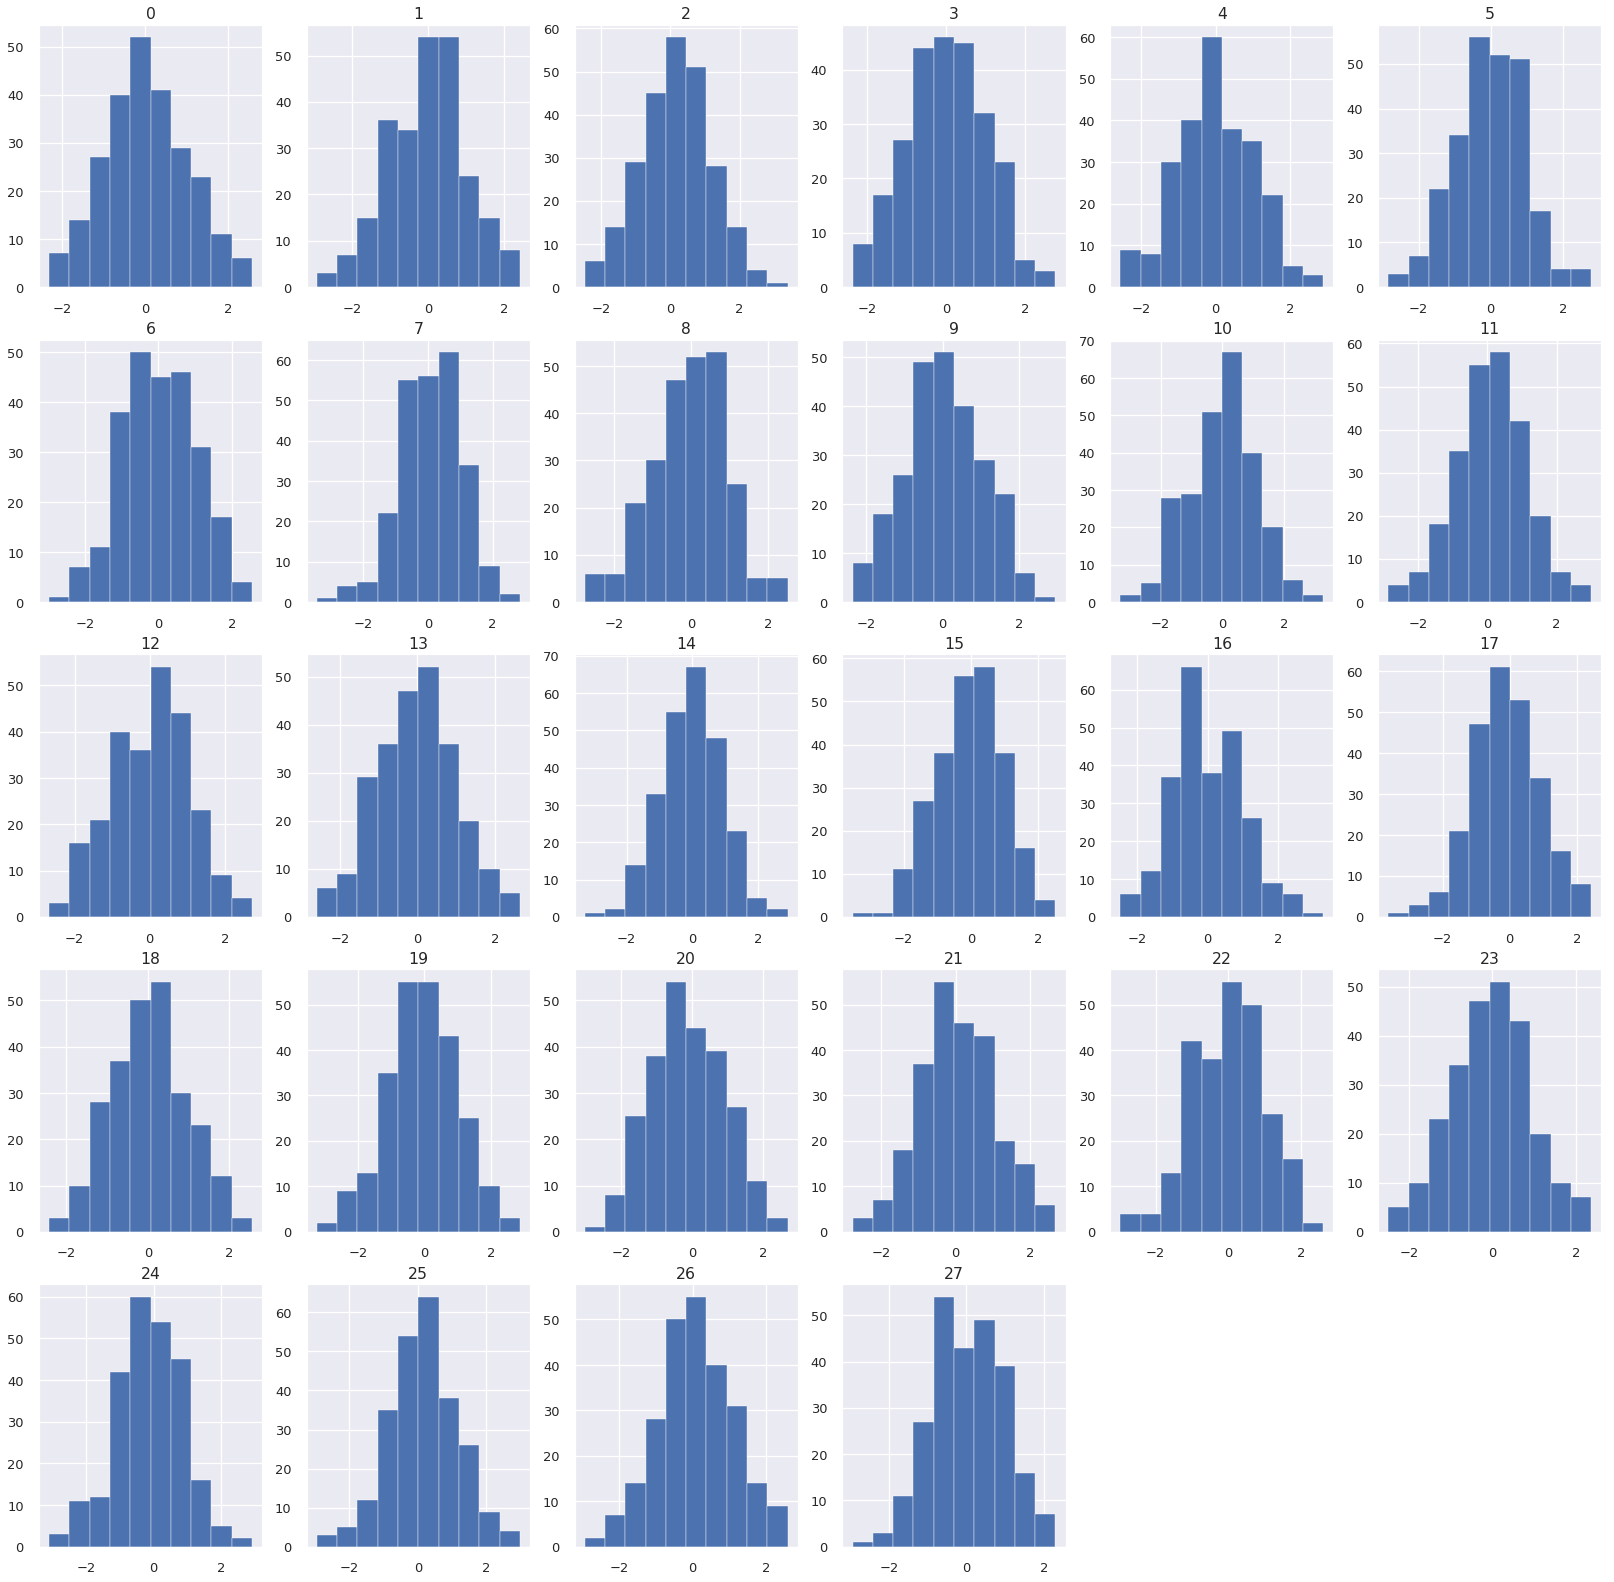

In [259]:
print("Distribution of first 28 columns")
plt.figure(figsize=(28,28))
for i,cols in enumerate(train.columns[2:30]):
  plt.subplot(5,6,i+1)
  plt.hist(train[cols])
  plt.title(cols)
  plt.grid(True)

Text(0.5, 1.0, 'Target')

Text(0, 0.5, '')

Text(0.5, 1.0, 'Target')

Text(0, 0.5, 'count')

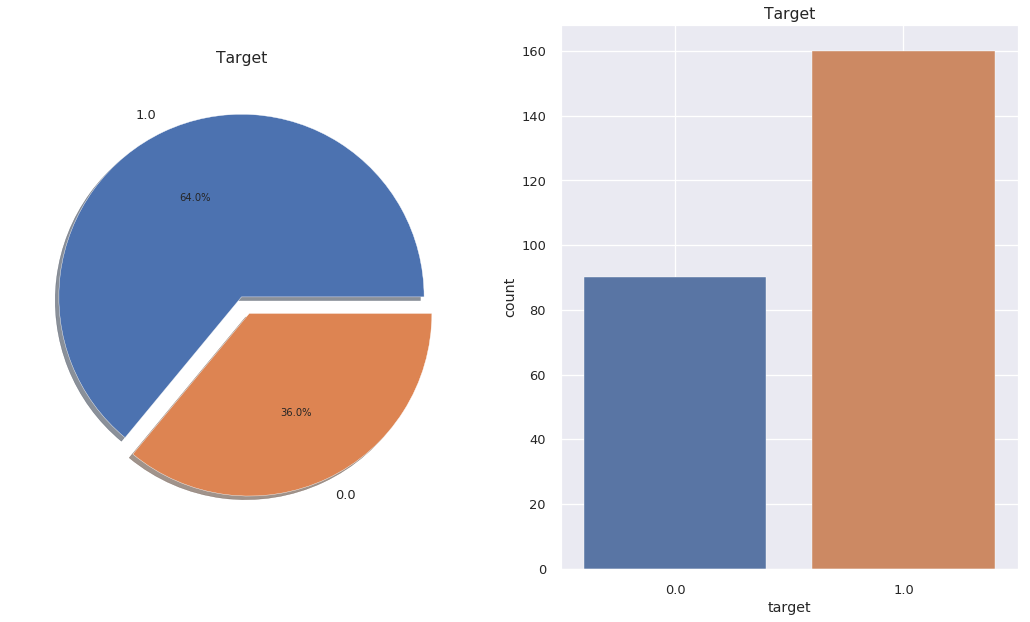

In [260]:
f, ax = plt.subplots(1,2,figsize=(18,10))
train['target'].value_counts().plot.pie(explode=[0,0.1],ax=ax[0],autopct='%1.1f%%',shadow=True)
ax[0].set_title('Target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('Target')
ax[1].set_ylabel('count')
plt.grid(True)
plt.show()

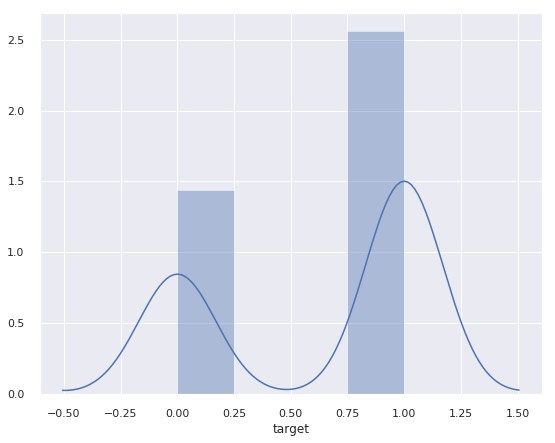

In [261]:
sns.set(rc={'figure.figsize':(9,7)})
sns.distplot(train['target'])

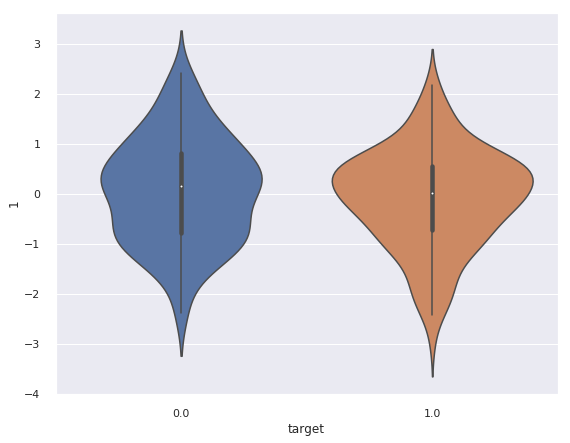

In [262]:
sns.violinplot(x='target',data=train,y='1')

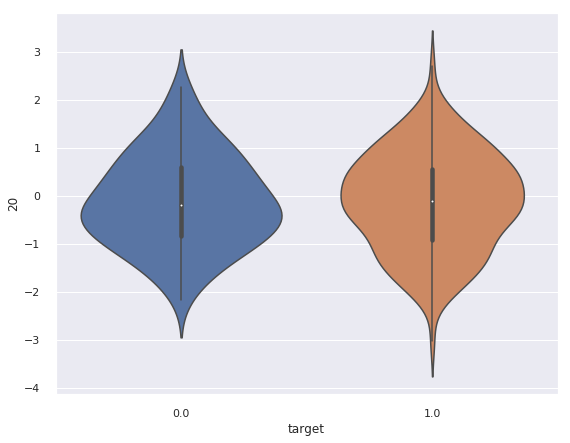

In [263]:
sns.violinplot(x='target',data=train,y='20')

### Ensemble Method

In [0]:
cols = ['id','target']
X = train.drop(cols,axis=1)
y = train['target']

In [0]:
X_test = test.drop("id",axis=1)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)

##### Random Forest

In [267]:
from sklearn.ensemble import RandomForestClassifier
Model=RandomForestClassifier(max_depth=2,n_estimators=100)
Model.fit(X_train,y_train)
y_pred=Model.predict(X_val)
print(classification_report(y_pred,y_val))
print(confusion_matrix(y_pred,y_val))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_val))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.62      0.77        50

   micro avg       0.62      0.62      0.62        50
   macro avg       0.50      0.31      0.38        50
weighted avg       1.00      0.62      0.77        50

[[ 0  0]
 [19 31]]
accuracy is  0.62


##### Bagging Classifier

In [268]:
from sklearn.ensemble import BaggingClassifier
bag_Model=BaggingClassifier()
Model.fit(X_train,y_train)
y_pred=Model.predict(X_val)
print(classification_report(y_pred,y_val))
print(confusion_matrix(y_pred,y_val))
#Accuracy Score
print('accuracy is ',accuracy_score(y_pred,y_val))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.62      0.77        50

   micro avg       0.62      0.62      0.62        50
   macro avg       0.50      0.31      0.38        50
weighted avg       1.00      0.62      0.77        50

[[ 0  0]
 [19 31]]
accuracy is  0.62


##### AdaBoost - Clssifier

In [269]:
from sklearn.ensemble import AdaBoostClassifier
Model = AdaBoostClassifier()
Model.fit(X_train, y_train)
y_pred = Model.predict(X_val)
print(classification_report(y_pred,y_val))
print(confusion_matrix(y_pred,y_val))
print(accuracy_score(y_pred, y_val))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

              precision    recall  f1-score   support

         0.0       0.37      0.70      0.48        10
         1.0       0.90      0.70      0.79        40

   micro avg       0.70      0.70      0.70        50
   macro avg       0.64      0.70      0.64        50
weighted avg       0.80      0.70      0.73        50

[[ 7  3]
 [12 28]]
0.7


##### Gradient Boosting Classifier

In [284]:
from sklearn.ensemble import GradientBoostingClassifier
Model = GradientBoostingClassifier()
Model.fit(X_train, y_train)
y_pred = Model.predict(X_val)
print(classification_report(y_pred, y_val))
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

              precision    recall  f1-score   support

         0.0       0.32      0.75      0.44         8
         1.0       0.94      0.69      0.79        42

   micro avg       0.70      0.70      0.70        50
   macro avg       0.63      0.72      0.62        50
weighted avg       0.84      0.70      0.74        50

[[ 6  2]
 [13 29]]
0.7


##### Linear Discriminant Analysis

In [271]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
Model = LinearDiscriminantAnalysis()
Model.fit(X_train,y_train)
y_pred = Model.predict(X_val)
print(classification_report(y_pred,y_val))
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred,y_val))

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

              precision    recall  f1-score   support

         0.0       0.37      0.44      0.40        16
         1.0       0.71      0.65      0.68        34

   micro avg       0.58      0.58      0.58        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.60      0.58      0.59        50

[[ 7  9]
 [12 22]]
0.58


##### Quadratic Discriminant Analysis

In [272]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
Model = QuadraticDiscriminantAnalysis()
Model.fit(X_train,y_train)
y_pred = Model.predict(X_val)
print(classification_report(y_pred,y_val))
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred,y_val))

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

              precision    recall  f1-score   support

         0.0       0.68      0.38      0.49        34
         1.0       0.32      0.62      0.43        16

   micro avg       0.46      0.46      0.46        50
   macro avg       0.50      0.50      0.46        50
weighted avg       0.57      0.46      0.47        50

[[13 21]
 [ 6 10]]
0.46


### Model Explainability

#### Feature Importance

In [273]:
perm = PermutationImportance(Model,random_state=0).fit(X_val, y_val)
eli5.show_weights(perm,feature_names=X.columns.to_list())

Weight,Feature
0.0600 ± 0.0566,291
0.0440 ± 0.0588,54
0.0400 ± 0.0253,276
0.0400 ± 0.0506,44
0.0360 ± 0.0160,294
0.0360 ± 0.0160,200
0.0360 ± 0.0299,12
0.0360 ± 0.0466,51
0.0360 ± 0.0466,27
0.0320 ± 0.0196,125


In [0]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)

In [0]:
from sklearn import tree
import graphviz

#### Partial Dependence Plots

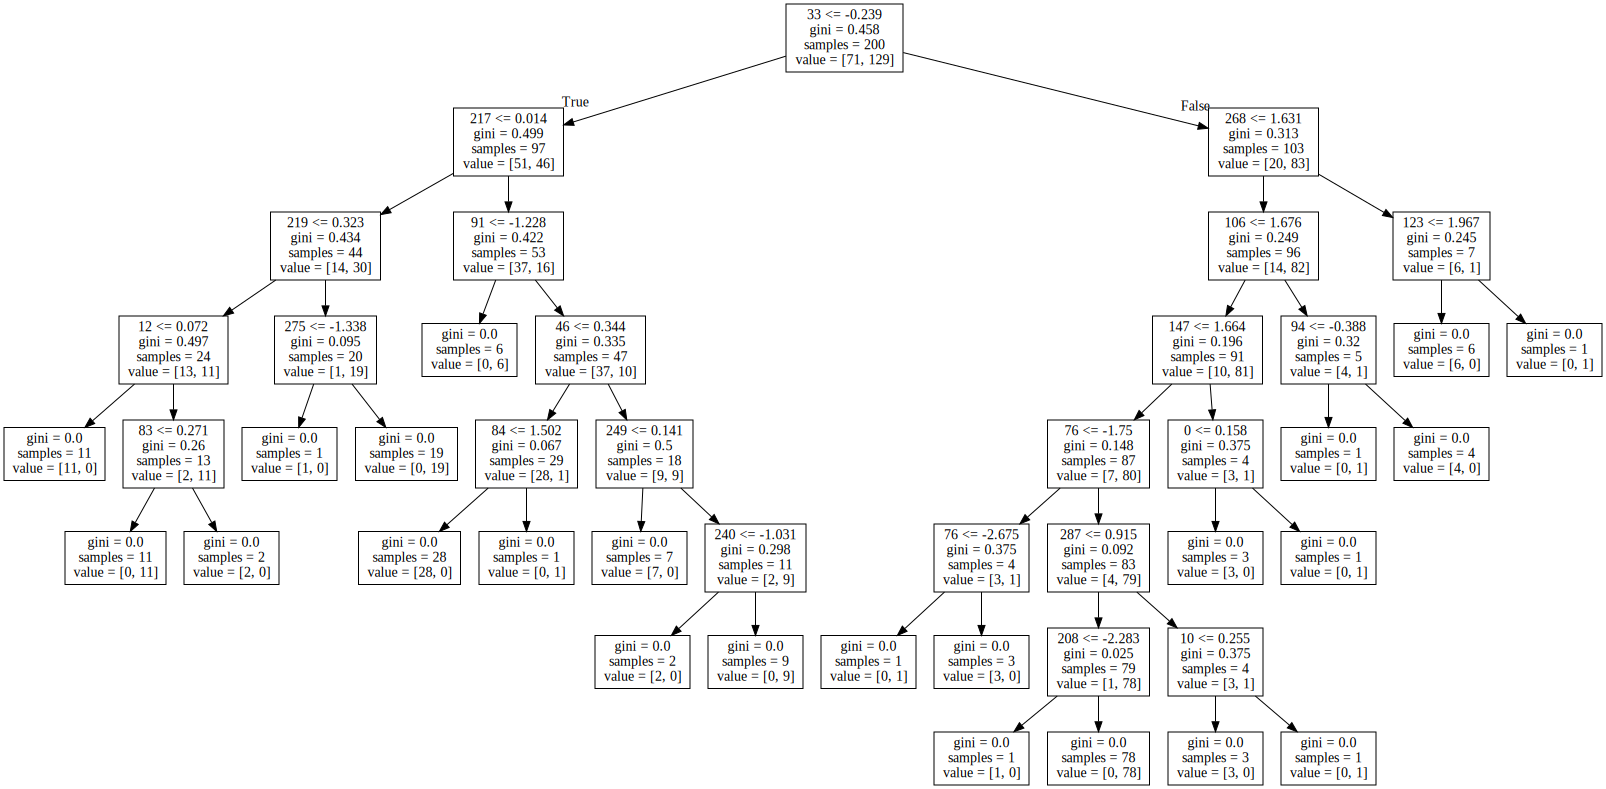

In [276]:
tree_graph = tree.export_graphviz(tree_model,out_file=None,feature_names=X_train.columns.to_list())
graphviz.Source(tree_graph)

In [0]:
from pdpbox import pdp, info_plots, get_dataset

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb70f6fd0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb7e94c50>})

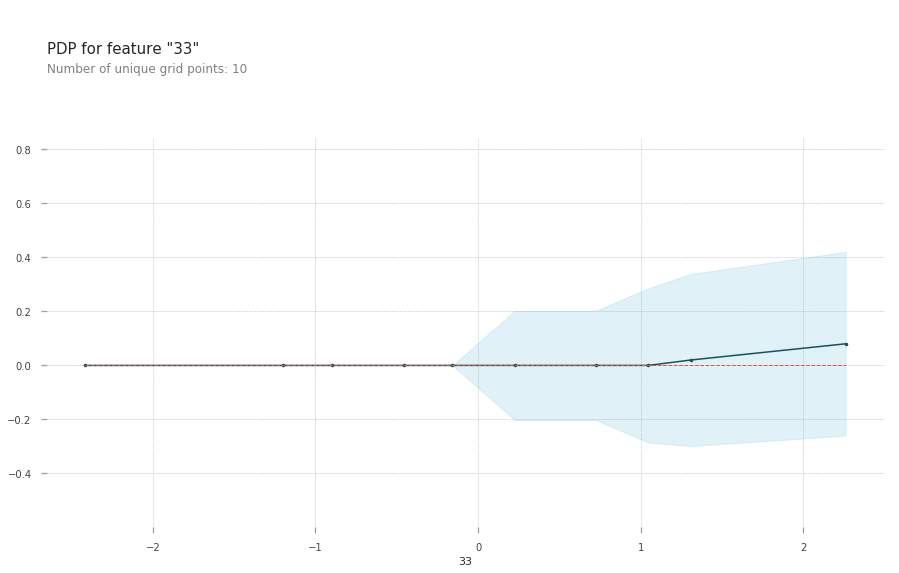

In [278]:
pdp_33 = pdp.pdp_isolate(model=Model,dataset=X_val,model_features=X_train.columns,feature="33")
pdp.pdp_plot(pdp_33,"33")

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb6fdc4e0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb7e2e470>})

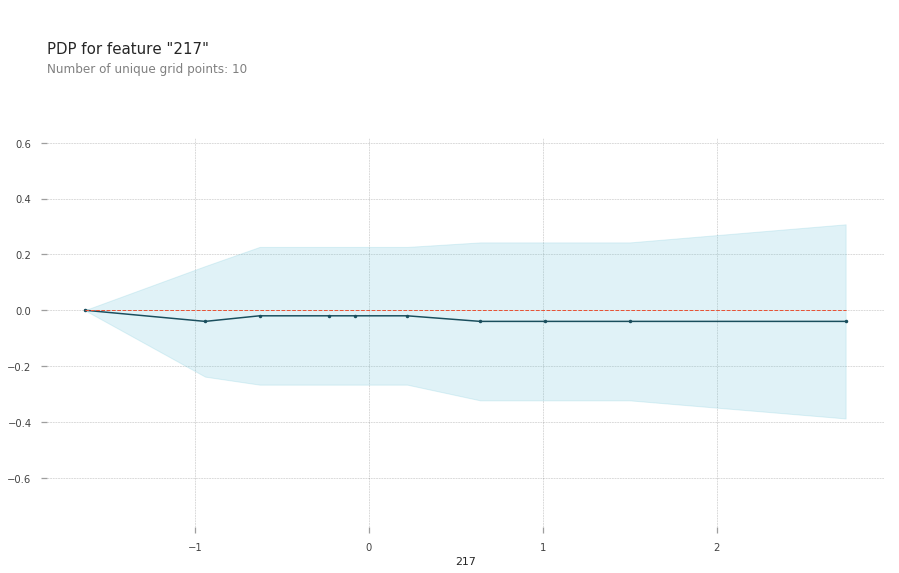

In [279]:
pdp_217 = pdp.pdp_isolate(model=Model,dataset=X_val,model_features=X_train.columns,feature="217")
pdp.pdp_plot(pdp_217,"217")

#### SHAP - Values

In [0]:
import shap

explainer = shap.TreeExplainer(model=Model)

shap_values = explainer.shap_values(X_train)

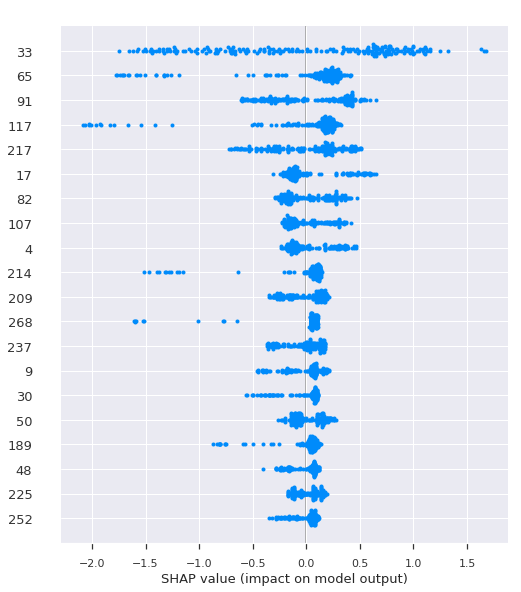

In [286]:
shap.summary_plot(shap_values,features=X_train.columns)

In [0]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], X_train.iloc[:,1:10])

### Building a Stronger Model

In [0]:
params = {'num_leaves': 9,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 16,
         'learning_rate': 0.0123,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'bagging_fraction': 0.8,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1.728910519108444,
         'reg_lambda': 4.9847051755586085,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'min_gain_to_split': 0.01077313523861969,
         'min_child_weight': 19.428902804238373,
         'num_threads': 4}

In [289]:
y_pred_lgb = np.zeros(len(X_test))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_boost_round=2000,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=300,early_stopping_rounds = 200)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Sun May  5 17:16:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 1 started at Sun May  5 17:16:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 2 started at Sun May  5 17:16:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 3 started at Sun May  5 17:16:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5
Fold 4 started at Sun May  5 17:16:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.5	valid_1's auc: 0.5


In [0]:
train_pool = Pool(X_train,y_train)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(X_train,y_train,silent=True)
y_pred_cat = cat_model.predict(X_val)
print(classification_report(y_pred_cat,y_val))
print(confusion_matrix(y_pred_cat,y_val))
print(accuracy_score(y_pred_cat,y_val))

In [295]:
import sys, os
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# some heuristic settings
rfe_min_features = 12
rfe_step = 15
rfe_cv = 20
sss_n_splits = 25
sss_test_size = 0.35
grid_search_cv = 25
noise_std = 0.01
r2_threshold = 0.185
random_seed = 213

np.random.seed(random_seed)

# import data
train = pd.read_csv('train.csv')
train_y = train['target']
train_X = train.drop(['id','target'], axis=1).values

test = pd.read_csv('test.csv')
test = test.drop(['id'], axis=1).values

# scale using RobustScaler
# fitting scaler on full data outperforms fitting on test_X only (+0.006 kaggle score)
data = RobustScaler().fit_transform(np.concatenate((train_X, test), axis=0))
train_X = data[:250]
test = data[250:]

# add a bit of noise to train_X to reduce overfitting
train_X += np.random.normal(0, noise_std, train_X.shape)

# define roc_auc_metric robust to only one class in y_pred
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

robust_roc_auc = make_scorer(scoring_roc_auc)

# define model and its parameters
model = Lasso(alpha=0.031, tol=0.01, random_state=random_seed, selection='random')

param_grid = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
        }

# define recursive elimination feature selector
feature_selector = RFECV(model, min_features_to_select=rfe_min_features, scoring=robust_roc_auc, step=rfe_step, verbose=0, cv=rfe_cv, n_jobs=-1)

print("counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count ")
print("-------------------------------------------------------------------------------------------------")

predictions = pd.DataFrame()
counter = 0
# split training data to build one model on each traing-data-subset
for train_index, val_index in StratifiedShuffleSplit(n_splits=sss_n_splits, test_size=sss_test_size, random_state=random_seed).split(train_X, train_y):
    X, val_X = train_X[train_index], train_X[val_index]
    y, val_y = train_y[train_index], train_y[val_index]

    # get the best features for this data set
    feature_selector.fit(X, y)
    # remove irrelevant features from X, val_X and test
    X_important_features        = feature_selector.transform(X)
    val_X_important_features    = feature_selector.transform(val_X)
    test_important_features     = feature_selector.transform(test)

    # run grid search to find the best Lasso parameters for this subset of training data and subset of features 
    grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0, n_jobs=-1, scoring=robust_roc_auc, cv=20)
    grid_search.fit(X_important_features, y)

    # score our fitted model on validation data
    val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
    val_mse = mean_squared_error(val_y, val_y_pred)
    val_mae = mean_absolute_error(val_y, val_y_pred)
    val_roc = roc_auc_score(val_y, val_y_pred)
    val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
    val_r2  = r2_score(val_y, val_y_pred)

    # if model did well on validation, save its prediction on test data, using only important features
    # r2_threshold (0.185) is a heuristic threshold for r2 error
    # you can use any other metric/metric combination that works for you
    if val_r2 > r2_threshold:
        message = '<-- OK'
        prediction = grid_search.best_estimator_.predict(test_important_features)
        predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
    else:
        message = '<-- skipping'


    print("{0:2}      | {1:.4f}   |  {2:.4f}   |  {3:.4f}   |  {4:.4f}   |  {5:.4f}    |  {6:.4f}    |  {7:3}         {8}  ".format(counter, val_mse, val_mae, val_roc, val_cos, val_dst, val_r2, feature_selector.n_features_, message))
    
    counter += 1

print("-------------------------------------------------------------------------------------------------")
print("{}/{} models passed validation threshold and will be ensembled.".format(len(predictions.columns), sss_n_splits))

mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.index += 250
mean_pred.columns = ['target']
mean_pred.to_csv('submission.csv', index_label='id', index=True)     

counter | val_mse  |  val_mae  |  val_roc  |  val_cos  |  val_dist  |  val_r2    | feature_count 
-------------------------------------------------------------------------------------------------


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 0      | 0.1983   |  0.3970   |  0.7321   |  0.8312   |  4.1776    |  0.1430    |  105         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 1      | 0.1879   |  0.3886   |  0.7494   |  0.8406   |  4.0667    |  0.1878    |   45         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 2      | 0.1914   |  0.3783   |  0.7651   |  0.8391   |  4.1045    |  0.1727    |   12         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 3      | 0.1917   |  0.3866   |  0.7706   |  0.8372   |  4.1070    |  0.1717    |   15         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 4      | 0.1966   |  0.3611   |  0.7561   |  0.8372   |  4.1590    |  0.1506    |   30         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 5      | 0.1812   |  0.3577   |  0.7846   |  0.8470   |  3.9931    |  0.2170    |   90         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 6      | 0.2129   |  0.3896   |  0.6758   |  0.8179   |  4.3286    |  0.0799    |  150         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 7      | 0.1603   |  0.3498   |  0.8382   |  0.8657   |  3.7556    |  0.3074    |   15         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 8      | 0.1986   |  0.3934   |  0.7416   |  0.8296   |  4.1805    |  0.1418    |   45         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

 9      | 0.1918   |  0.3972   |  0.7651   |  0.8359   |  4.1087    |  0.1710    |   30         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

10      | 0.2200   |  0.4021   |  0.7020   |  0.8089   |  4.3996    |  0.0494    |  135         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

11      | 0.1793   |  0.3510   |  0.7829   |  0.8482   |  3.9725    |  0.2251    |   12         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

12      | 0.1946   |  0.3825   |  0.7634   |  0.8332   |  4.1380    |  0.1591    |   12         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

13      | 0.1939   |  0.3818   |  0.7483   |  0.8338   |  4.1312    |  0.1619    |   90         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

14      | 0.1892   |  0.3688   |  0.7483   |  0.8392   |  4.0799    |  0.1826    |   12         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

15      | 0.2107   |  0.3976   |  0.7561   |  0.8185   |  4.3060    |  0.0895    |   15         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

16      | 0.1770   |  0.3647   |  0.8036   |  0.8498   |  3.9471    |  0.2349    |  195         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

17      | 0.1950   |  0.3712   |  0.7606   |  0.8346   |  4.1428    |  0.1572    |   75         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

18      | 0.2302   |  0.4215   |  0.6546   |  0.7995   |  4.5010    |  0.0051    |  120         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

19      | 0.1995   |  0.3769   |  0.7517   |  0.8344   |  4.1897    |  0.1380    |  135         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

20      | 0.2103   |  0.3806   |  0.7171   |  0.8244   |  4.3017    |  0.0913    |   12         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

21      | 0.1851   |  0.3653   |  0.7779   |  0.8436   |  4.0355    |  0.2003    |   12         <-- OK  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

22      | 0.2068   |  0.3998   |  0.7132   |  0.8232   |  4.2660    |  0.1063    |  195         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

23      | 0.1943   |  0.3807   |  0.7578   |  0.8337   |  4.1354    |  0.1602    |   45         <-- skipping  


RFECV(cv=20,
   estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
   min_features_to_select=12, n_jobs=-1,
   scoring=make_scorer(scoring_roc_auc), step=15, verbose=0)

GridSearchCV(cv=20, error_score='raise-deprecating',
       estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=213,
   selection='random', tol=0.01, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031], 'tol': [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(scoring_roc_auc), verbose=0)

24      | 0.1844   |  0.3648   |  0.7891   |  0.8430   |  4.0278    |  0.2033    |   30         <-- OK  
-------------------------------------------------------------------------------------------------
7/25 models passed validation threshold and will be ensembled.


In [296]:
from google.colab import files
files.upload()

Saving submission.csv to submission (1).csv


{'submission.csv': b'id,target\n250,0.7411772890706871\n251,0.5285285831751481\n252,0.6348007974466118\n253,0.7981217817333736\n254,0.5747955908956924\n255,0.48099511569021836\n256,0.524827934939682\n257,0.4026533572408587\n258,0.7433490612953639\n259,0.5488833120944356\n260,0.7500355639575383\n261,0.49586627144269135\n262,0.37737642215784967\n263,0.7962500830581771\n264,0.5305328305506972\n265,0.7922472779607354\n266,0.6377443235959401\n267,0.9274712653548143\n268,0.5029394810113275\n269,0.43210242784473574\n270,0.618994281075672\n271,0.8607749371220044\n272,0.6202033697974384\n273,0.6504841374851787\n274,0.48935931088326867\n275,0.6951494944711399\n276,0.11334372386181428\n277,0.7915633334688252\n278,0.7954911716187832\n279,0.5859291278124262\n280,0.3941138740398411\n281,0.44245940734104244\n282,0.5177571204050005\n283,0.2655963690796044\n284,0.7640786913646473\n285,0.5442572916201943\n286,0.603679264207362\n287,0.6960092417101641\n288,0.8987131531301585\n289,1.074652336899821\n290,0

In [0]:
prev_sub = pd.read_csv('submission (1).csv')

In [0]:
current_sub = pd.read_csv('submission.csv')

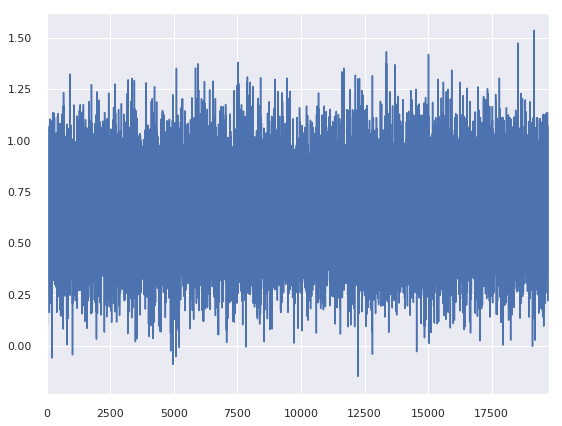

In [305]:
current_sub['target'].plot()

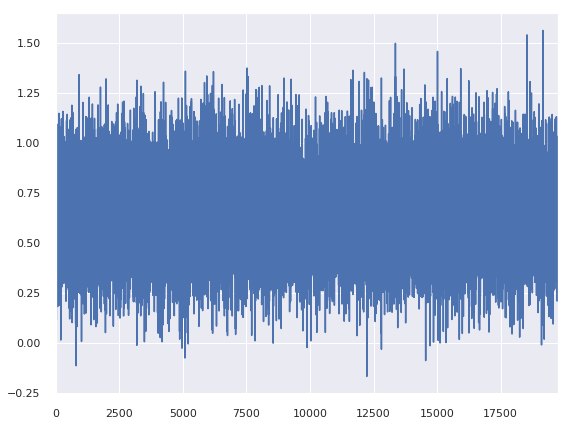

In [304]:
prev_sub['target'].plot()